<h1  style="color:white; background-color: #154360; padding:30px;"> 
Résultats numériques pour l'algorithme Deep Q-Learning en dimension 1  </h1>

Dans ce notebook, je présente les résultats de mon algorithme Deep Optimal Stopping. 
Des références pour comprendre DQN pour l'arrêt optimal: 
- [Solving optimal stopping problems with Deep Q-Learning](https://arxiv.org/pdf/2101.09682)
- [Deep Reinforcement learning for optimal stopping](https://arxiv.org/pdf/2105.08877)

In [49]:
import sys
import helper_plots


sys.path.append("..")


import numpy as np

import src.tools.diffusion.black_scholes as bs
import torch
from torch import nn
from tqdm import tqdm
import seaborn as sns


import matplotlib.pyplot as plt
import pandas as pd

import src.main.dqn.dqn as dqn
import src.main.dqn.agent as agent
import src.tools.option.option_main_class as option

<h3  style="color:white; background-color: #9C33FF; padding:15px;"> 
Put Bermudéen  </h3>

In [50]:
strike = 40
r = 0.06
vol = 0.2
spot = 40
maturity = 1

list_weights = [40,20]
activation_function = nn.ReLU()
n_simulation = 50
epsilon = 0.01
epsilon_decay = 0.001
epsilon_max = 0.99
learning_rate = 1e-2
d = 1
batch_size = 500
replay_memory_init = 5000
replay_memory_capacity = 100000
N_update = 50


myagent = agent.Agent(
    epsilon,
    epsilon_decay,
    epsilon_max,
    replay_memory_init,
    replay_memory_capacity,
    N_update,
    learning_rate,
    batch_size,
    activation_function,
    list_weights,
    d,
)

process = bs.BlackScholes(spot, r, vol)
put_option_payoff = lambda x: max(strike - x, 0)
option_ = option.Option(maturity, strike, r, put_option_payoff)


dqn_object = dqn.dqn(process, option_, myagent)

In [51]:
n_episodes = 6000
rewars, rewards_batch, losses, pos, epsilon, exploit_explore, myagent = (
    dqn_object.train(
        n_simulation, n_episodes, start_of_training=800, disable=False, seed=2024
    )
)

  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [05:35<00:00, 17.88it/s]


In [52]:
count = 0
while losses[count] == 0:
    count += 1
start_training = count
print(f"started training at {start_training} epoch")

started training at 801 epoch


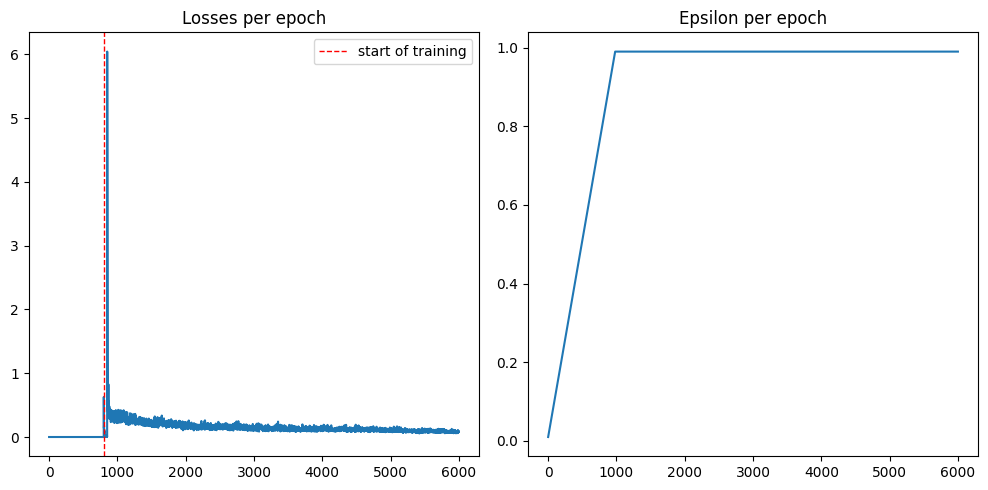

In [53]:
# Use the inline backend to display plots inline within the notebook
%matplotlib inline

# Create a figure
plt.figure(figsize=(10, 5))

# First subplot
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Losses per epoch')
plt.axvline(x=start_training, color='r', linestyle='--', linewidth=1, label='start of training')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(epsilon)
plt.title('Epsilon per epoch')

# Show the plots
plt.tight_layout()
plt.show()

C:\Users\amaury.manzione\AppData\Local\Temp\ipykernel_18448\2219437610.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


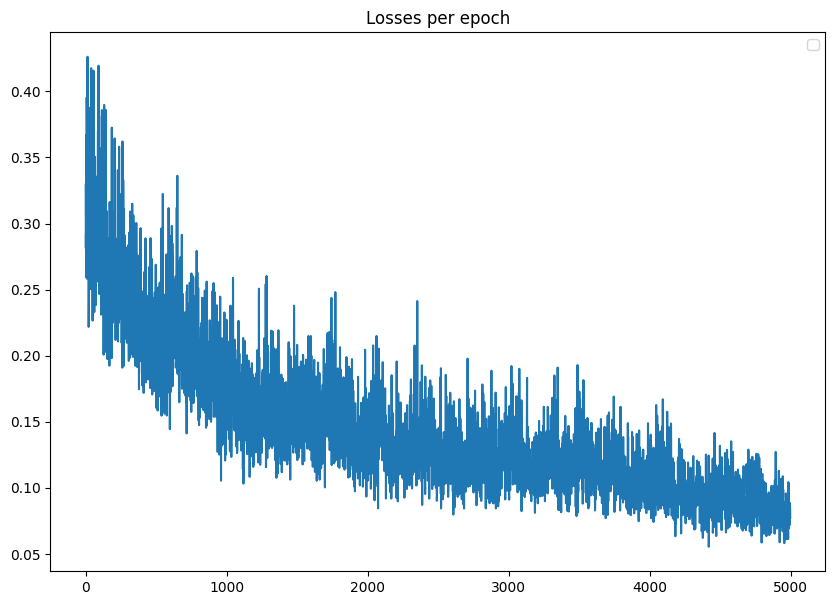

In [54]:
plt.figure(figsize=(10, 7))

# First subplot
plt.plot(losses[1000:-1])
plt.title('Losses per epoch')
plt.legend()

In [55]:
n = rewards_batch.shape[0]
history_mean = [torch.mean(rewards_batch[i:i+100]) for i in range(200, n-100)]

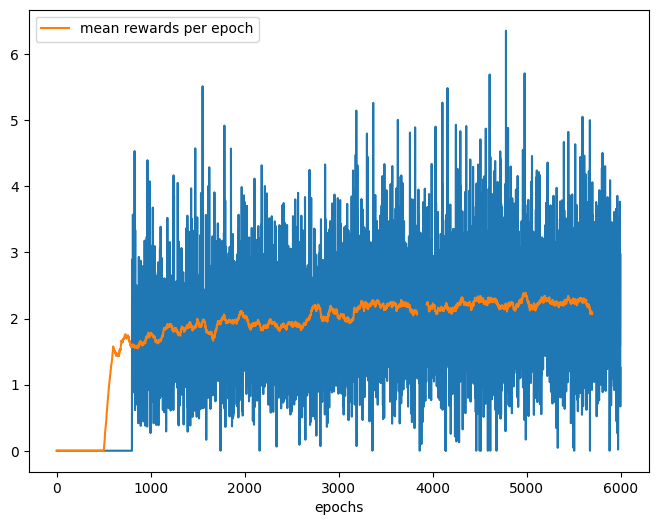

In [56]:
plt.figure(figsize=(8, 6))
plt.plot(rewards_batch)
plt.plot(history_mean, label="mean rewards per epoch")
plt.xlabel("epochs")
plt.legend()

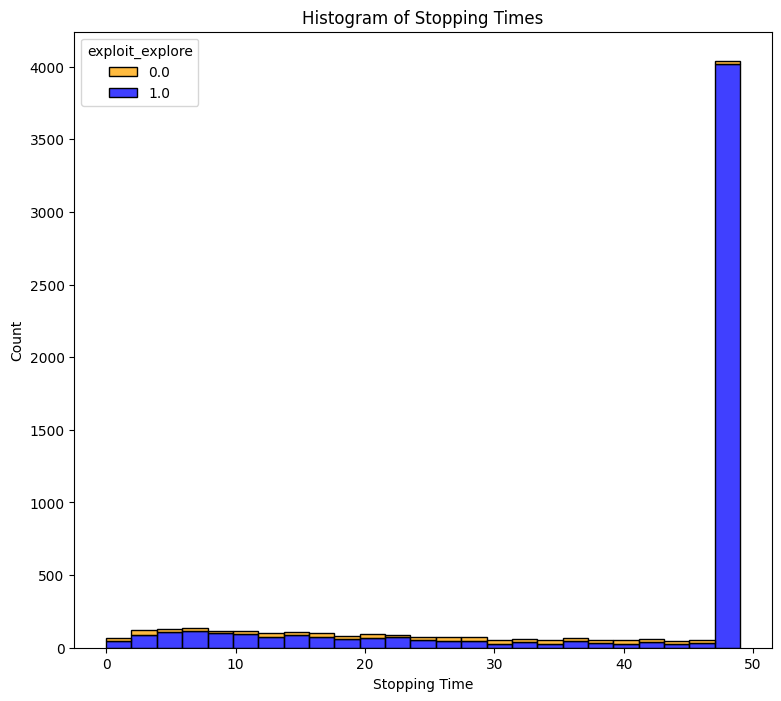

In [57]:
plt.figure(figsize=(9, 8))

df = pd.DataFrame({"pos": pos, "exploit_explore": exploit_explore})

# Create the histplot with different colors for "exploit" and "explore"
sns.histplot(
    data=df,
    x="pos",
    hue="exploit_explore",
    multiple="stack",
    palette={1: "blue", 0: "orange"},
)

# Add titles and labels
plt.title("Histogram of Stopping Times")
plt.xlabel("Stopping Time")
plt.ylabel("Count")

# Show the plot
plt.show()

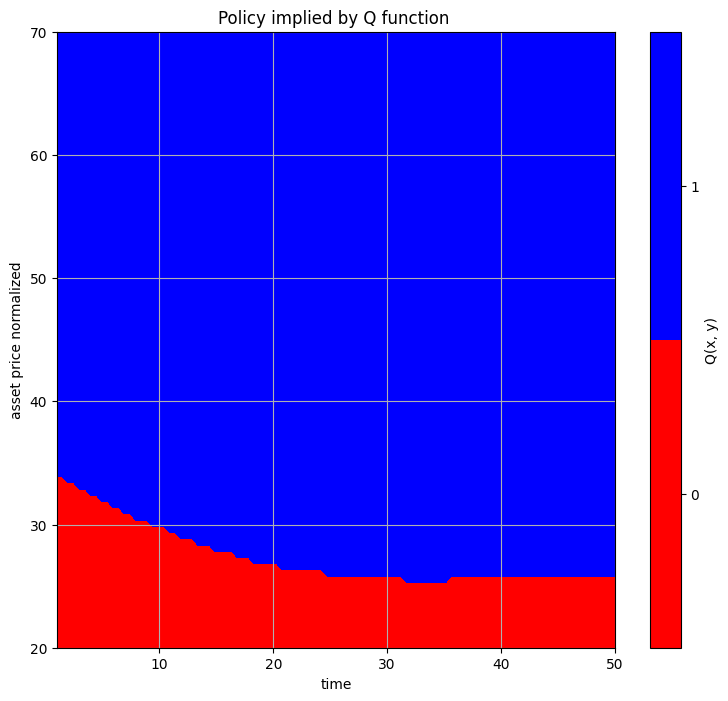

In [58]:
# Define the grid
y = np.linspace(20, 70, 100)
x = np.linspace(1, 50, 100)
X, Y = np.meshgrid(x, y)

# myagent.online_network.eval()

def f(x, y):
    input_to_tensor = torch.tensor(np.array([y, x]))
    policy = myagent.get_policy(input_to_tensor)
    return policy


# Evaluate the function on the grid
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f(X[i, j], Y[i, j])

# Plot the results with specified colors
plt.figure(figsize=(9, 8))
plt.contourf(X, Y, Z, levels=[-0.5, 0.5, 1.5], colors=["red", "blue"])
plt.colorbar(ticks=[0, 1], label="Q(x, y)")
plt.title("Policy implied by Q function ")
plt.xlabel("time")
plt.ylabel("asset price normalized")
plt.grid()
plt.show()

In [59]:
dqn_object.get_price(myagent, n_simulation, 20000)

100%|██████████| 20000/20000 [04:06<00:00, 81.14it/s] 


(2.2921372571844993, 3.0991253950767366, 1.485149119292262)

<h3  style="color:white; background-color: #9C33FF; padding:15px;"> 
Tuning avec Optuna  </h3>

In [60]:
# import optuna 
# from multiprocessing import cpu_count

In [61]:
# strike = 40
# r = 0.06
# vol = 0.2
# spot = 36 
# maturity = 1

# list_weights = [20]
# activation_function = nn.ReLU()
# n_simulation = 10
# epsilon = 0.01
# epsilon_decay = 0.002
# epsilon_max = 0.99
# learning_rate = 1e-2
# d = 1

In [62]:
# num_episodes = 5000


# def objective(trial):

#     list_batch = np.arange(start=20, stop=500, step=20, dtype=int).tolist()

#     list_N_update = np.arange(start=10, stop=300, step=10, dtype=int).tolist()

#     batch_size_list = trial.suggest_categorical("batch_size", list_batch)

#     learning_rate_list = trial.suggest_float("learning_rate", 1e-6, 1e-1)

#     N_update_list = trial.suggest_categorical("N_update", list_N_update)

#     myagent = agent.Agent(
#         epsilon,
#         epsilon_decay,
#         epsilon_max,
#         batch_size_list,
#         replay_memory_capacity,
#         N_update_list,
#         learning_rate_list,
#         batch_size_list,
#         activation_function,
#         list_weights,
#         d,
#     )

#     option_ = option.Option(maturity, strike, r, put_option_payoff)
#     dqn_object = dqn.dqn(process, option_, myagent)

#     rewards, rewards_batch, losses, pos, epsilon_, exploit_explore, myagent = (
#         dqn_object.train(n_simulation, num_episodes, disable=True, seed=2024)
#     )

#     return torch.mean(rewards[-200:]), losses[-1]

In [63]:
# study = optuna.create_study(
#     study_name="tuning_put_option",
#     storage="sqlite:///put_option.db",
#     directions=["maximize", "minimize"],
#     load_if_exists=True,
# )

In [64]:
# number_cores = cpu_count()

# study.optimize(objective, n_trials=80, n_jobs=number_cores)

# print("Best trials:")
# for i, trial in enumerate(study.best_trials):
#     print(f"Trial {i}:")
#     print("  Values: ", trial.values)
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print(f"    {key}: {value}")